# Deep Learning - Intro to TensorFlow from Scratch

- Nama            : Arman Dwi Pangestu
- NIM             : 1221604
- Program Studi   : Teknik Informatika
- Semester        : 7 Antara (Ganjil)
- Mata Kuliah     : Deep Learning
- Dosen           : Mina Ismu Rahayu
- Tugas           : Tugas 1 - Eksplorasi TensorFlow from Scracth
- Tanggal         : Minggu, 28 Juli 2024

<h1 align="center">TensorFlow Neural Network Lab</h1>

---



<img src="image/notmnist.png">
In this lab, you'll use all the tools you learned from *Introduction to TensorFlow* to label images of English letters! The data you are using, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consists of images of a letter from A to J in different fonts.

The above images are a few examples of the data you'll be training on. After training the network, you will compare your prediction model against test data. Your goal, by the end of this lab, is to make predictions against that test set with at least an 80% accuracy. Let's jump in!

> **Eksplorasi**: Pada lab kali ini, saya akan menggunakan semua tools untuk belajar dari *pengenalan pada TensorFlow* untuk melakukan labeling gambar dari huruf bahasa inggris, data yang akan digunakan berasal dari notMNIST, yang mengandung gambar berupa huruf dari A sampai J dengan font yang berbeda-beda.

> **Eksplorasi**: Gambar diatas adalah beberapa contoh data yang akan saya lakukan training. Setelah jaringan/network di training, saya akan melakukan perbandingan dengan prediction model dengan data testing. Tujuan saya, pada akhir lab ini, adalah membuat prediksi dengan data test yang di set dengan akurasi setidaknya sebanyak 80%.

To start this lab, you first need to import all the necessary modules. Run the code below. If it runs successfully, it will print "`All modules imported`".

> **Eksplorasi**: Untuk memulai nya, saya perlu melakukan import semua module yang dibutuhkan. Untuk melakukannya jalankan code dibawah ini

In [1]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


The notMNIST dataset is too large for many computers to handle.  It contains 500,000 images for just training.  You'll be using a subset of this data, 15,000 images for each label (A-J).

> **Eksplorasi**: dataset notMNIST terlalu banyak untuk beberapa komputer yang akan menghandle nya. Dataset tersebut mengandung 500,000 gambar hanya untuk training. Saya akan menggunakan subset dari data tersebut sebesar 15,000 gambar untuk setiap label (A-J)

> **Eksplorasi**: Untuk melakukannya pertama disini kita download terlebih dahulu dataset notMNIST nya menggunakan library `urlretrieve` setelah itu kita lakukan pengecekan checksum file nya apakah sama atau tidak, jika tidak sama maka file tersebut corrupt.

In [2]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

Download Finished
Download Finished
All files downloaded.


> **Eksplorasi**: Setelah file berhasil di download dan dilakukan pengecekan checksum, selanjutnya dilakukan uncompress/unzip file dataset tersebut menggunakan library `ZipFile` dan library `tqdm` untuk memunculkan progress bar

> **NOTE**: Feature adalah data dari gambar yang diload, biasanya berupa angka-angka yang merepresentasikan warna-warna pada setiap pixel nya (jika RGB maka bentuknya 3 dimensi yaitu RGB), kemudian data tersebut di konversi menjadi array 1 dimensi atau biasa disebut dengan flatten dan disimpan ke memori dengan tipe data float32

> 1. Buat function untuk melakukan pengecekan saat proses uncompress/unzip apakah yang dicek isinya file atau directory
> 2. Jika file maka simpan kedalam feature dengan cara load image data nya menjadi array 1 dimensi (`flatten`) dengan tipe data `float32` pada memory nya
> 3. Setelah feature nya diambil, sekarang ambil data label huruf dari gambar tersebut
> 4. Selanjutnya simpan data feature dan label tersebut kedalam array kosong
> 5. Return dari function tersebut dengan data array feature dan label
> 6. Selanjutnya buat 2 buah variable `train_features`, `train_labels` dan `test_features`, `test_labels` untuk menyimpan data train dan juga data test dari dataset notMNIST, kemudian isikan variable tersebut dengan cara memanggil function yang sudah dibuat
> 7. Selanjutnya lakukan `resample` dataset train notMNIST tersebut yang berisi `500,000` gambar menjadi `15,000`
> 8. Selanjutnya buat inisialisasi variable `is_fetatures_normal` dan `is_labels_encod` untuk state pada data pre-processing

In [3]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')

        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|██████████| 10001/10001 [00:02<00:00, 3987.08files/s]


All features and labels uncompressed.


<img src="image/Mean_Variance_Image.png" style="height: 75%;width: 75%; position: relative; right: 5%">
## Problem 1
The first problem involves normalizing the features for your training and test data.

Implement Min-Max scaling in the `normalize_grayscale()` function to a range of `a=0.1` and `b=0.9`. After scaling, the values of the pixels in the input data should range from 0.1 to 0.9.

Since the raw notMNIST image data is in [grayscale](https://en.wikipedia.org/wiki/Grayscale), the current values range from a min of 0 to a max of 255.

Min-Max Scaling:
$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$

*If you're having trouble solving problem 1, you can view the solution [here](https://github.com/udacity/deep-learning/blob/master/intro-to-tensorflow/intro_to_tensorflow_solution.ipynb).*

> **Eksplorasi**: Problem 1: Problem pertama adalah melibatkan normalisasi feature dari data training dan test.
> Implementasi Min-Max scaling pada function `normalize_grayscale()` untuk sebuah rentang dari `a=0.1` dan `b=0.9`. Setelah scaling, value dari pixel input data harus berada pada rentang `0.1` dan `0.9`.
> Dikarenakan raw data dari dataset gambar notMNIST adalah data `grayscale`, maka rentang value nya berada di minimum `0` dan maximum `255`.
>
> Rumus dari Min-Max Scaling adalah:
> $
> X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
> $
>
> 1. Buat function dengan nama `normalize_grayscale(image_data)` yang menerima data feature dari gambar yang sudah di flatten sebelumnya
> 2. Lakukan operasi dari rumus Min-Max Scaling diatas pada isian dari function tersebut dengan cara mendefinisikan beberapa variable yang diperlukan seperti, nilai range untuk `a` dan `b` yang diinginkan adalah `0.1` dan `0.9`. Selanjutnya definisikan juga nilai `X_min` dan `X_max` dari original data nya (dikarenakan pada kasus ini menggunakan data grayscale dari notMNIST dan sudah di flatten maka value nya sekitar `0` hingga `255`
> 3. Setelah mendefinisikan variabel-variabel yang dibutuhkan selanjutnya lakukan kalkulasi atau perhitungan berdasarkan rumus Min-Max Scaling tersebut dan jika sudah selesai maka lakukan return data nya
> 4. Selanjutnya lakukan uji kasus apakah function nya sudah sesuai yang diharapkan berdasarkan rumus Min-Max scaling tersebut, lakukan dengan sample data menggunakan numpy testing dan `assert_array_almost_equal`, parameter pertama berikan sampel data array 1 dimensi (sebagai sample data yang sudah di `flatten`), selanjutnya pada parameter kedua berikan sample value kisaran data yang mungkin mendekati dari hasil normalisasi grayscale dari rumus Min-Max scaling tersebut.
> 5. Jika normal, maka sekarang lakukan normalisasi untuk data `training_features` dan `test_features`

In [4]:
# Problem 1 - Implement Min-Max scaling for grayscale image data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    # Rumus dari Min-Max Scaling: X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
    # Min dan Max values untuk range yang diinginkan
    a = 0.1
    b = 0.9

    # Min and Max values untuk original data (data feature yang sudah di flatten)
    X_min = 0
    X_max = 255

    # Melakukan perhitungan atau kalkulasi untuk Min-Max scaling
    X_prime = a + ((image_data - X_min) * (b - a)) / (X_max - X_min)

    return X_prime


### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

print('Tests Passed!')

Tests Passed!


> **Eksplorasi**: Setelah melakukan normalisasi grayscale pada data feature, selanjutnya kita lakukan konversi atau transform atau ubah data label menjadi binary dengan One-Hot Encoding
>
> Sebagai contoh, data label yang digunakan adalah berisi kategorikal seperti `A, B, C, ..., J`. Nah, data tersebut rupanya sulit untuk dipahami oleh model machine learning atau deep learning pada saat proses pemilihan fully-connected layer output atau dense layer output seperti menggunakan algoritma softmax. Oleh karena itu, kita perlu mengubah data label tersebut menjadi numerical, seperti misalkan A, B, C. Maka `A = [1, 0, 0]`, `B = [0, 1, 0]`, dan `C = [0, 0, 1]`

In [5]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


> **Eksplorasi**: Setelah proses normalisasi grayscale dan transform label menjadi binary. Selanjutnya melakukan proses Randomize dan split dataset untuk training dan validation. Mengapa hal ini diperlukan?
> 1. **Menghindari overfitting**: Memiliki set data terpisah untuk pelatihan (training) dan validasi (validation) memungkinkan kita memeriksa apakah model kita hanya menghafal data pelatihan atau benar-benar belajar pola yang dapat digeneralisasikan ke data baru. Tanpa pemisahan ini, kita tidak dapat menilai kinerja model pada data yang belum pernah dilihat sebelumnya.
> 2. **Meningkatkan Generalisasi**: Dengan membagi dataset menjadi bagian training dan validation, kita bisa memastikan bahwa model kita belajar dari data yang representatif dari seluruh dataset, bukan hanya dari subset tertentu. Ini membantu model untuk lebih baik dalam mengeneralisasi ke data yang tidak terlihat.
> 3. **Menyediakan Evaluasi yang Akurat**: Validasi selama pelatihan memberikan kita pandangan tentang bagaimana model kita berkinerja pada data yang tidak dilihat selama pelatihan. Ini membantu kita mengatur hyperparameter model dan memilih model terbaik berdasarkan kinerja pada data validation.
>
> **NOTE**:
> 1. parameter `test_size=0.05` artinya adalah kita menentukan proporsi data yang akan digunakan untuk set validasi. Artinya, `5%` dari data akan digunakan untuk validasi dan `95%` untuk pelatihan.
> 2. parameter `random_state=832289` adalah seed untuk generator angka acak yang digunakan untuk memastikan bahwa pemisahan dataset dapat direproduksi. Ini berarti setiap kali Anda menjalankan kode, pemisahan akan sama, yang penting untuk konsistensi dalam eksperimen dan pelaporan.
>
> **Bagaimana Cara Kerja Random State?**
> Misalkan kita memiliki dataset yang terdiri dari `10` angka, yaitu `1` sampai `10`. Sekarang, jika kita ingin membaginya menjadi dataset pelatihan dan pengujian, dengan ukuran dataset pengujian sebesar `20%` dari keseluruhan dataset, maka dataset pelatihan akan terdiri dari `8` sampel data, sedangkan dataset pengujian akan terdiri dari `2` sampel data.
>
> Penting untuk memastikan bahwa proses pengacakan dataset menghasilkan hasil yang konsisten setiap saat, sehingga kode dapat direproduksi. Tanpa pengacakan dataset, setiap eksekusi kode dapat menghasilkan dataset yang berbeda, yang tidak ideal untuk melatih model karena setiap latihan menggunakan data yang berbeda. Oleh karena itu, setiap kali kita ingin mengacak dataset, kita menggunakan nilai `random_state`. Ini memastikan bahwa satu nilai `random_state` menghasilkan pengacakan yang konsisten, sehingga setiap kali kode dijalankan dengan nilai `random_state` yang sama, akan menghasilkan pembagian dataset yang serupa. Ini sangat penting utnuk memastikan konsistensi dalam percobaan dan evaluasi model.

In [6]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


> **Eksplorasi**: Setelah melakukan randomize dan split data, selanjutnya kita perlu menyimpan data dalam bentuk pickle. Mengapa perlu melakukannya?
> 1. **Akses yang cepat dan mudah**: Setelah melakukan pre-processing, seperti normalisasi feature dan one-hot encoding label, serta membagi dataset, proses ini bisa memakan waktu lama. Menyimpan data yang telah diproses dalam file pickle memungkinkan akses cepat dan mudah ke data ini tanpa harus mengulang langkah pre-processing setiap kali.
> 2. **Konsistensi Data**: Dengan menyimpan data yang telah diproses, Anda memastikan bahwa setiap kali data di-load kembali, kondisinya tetap sama. Ini penting untuk konsistensi dalam eksperimen dan pelatihan model.
> 3. **Menghemat waktu dan sumber daya**: Proses pre-processing dapat memakan banyak waktu dan sumber daya komputasi. Dengan menyimpan data yang telah diproses, Anda menghemat waktu dan sumber daya karena tidak perlu mengulang proses tersebut setiap kali ingin menggunakan data.
> 4. **Keperluan pengembangan dan eksplorasi**: Saat mengembangkan dan mengeksplorasi model machine learning, Anda mungkin akan sering memuat dan mengubah data. Menyimpan data dalam bentuk pickle memungkinkan pengembang untuk fokus pada pengembangan model tanpa harus khawatir tentang pre-processing yang berulang.

In [7]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


# Checkpoint
All your progress is now saved to the pickle file.  If you need to leave and comeback to this lab, you no longer have to start from the beginning.  Just run the code block below and it will load all the data and modules required to proceed.

> **Eksplorasi**: Melakukan inisialisai variabel yang dibutuhkan berdasarkan atau menggunakan data yang sudah disimpan dengan pickle sehingga tidak perlu melakukan pre-processing seperti normalisasi, one-hot encoding label, serta membagi dataset.

In [8]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.



## Problem 2

Now it's time to build a simple neural network using TensorFlow. Here, your network will be just an input layer and an output layer.

<img src="image/network_diagram.png" style="height: 40%;width: 40%; position: relative; right: 10%">

For the input here the images have been flattened into a vector of $28 \times 28 = 784$ features. Then, we're trying to predict the image digit so there are 10 output units, one for each label. Of course, feel free to add hidden layers if you want, but this notebook is built to guide you through a single layer network.

For the neural network to train on your data, you need the following <a href="https://www.tensorflow.org/resources/dims_types.html#data-types">float32</a> tensors:
 - `features`
  - Placeholder tensor for feature data (`train_features`/`valid_features`/`test_features`)
 - `labels`
  - Placeholder tensor for label data (`train_labels`/`valid_labels`/`test_labels`)
 - `weights`
  - Variable Tensor with random numbers from a truncated normal distribution.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#truncated_normal">`tf.truncated_normal()` documentation</a> for help.
 - `biases`
  - Variable Tensor with all zeros.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#zeros"> `tf.zeros()` documentation</a> for help.

*If you're having trouble solving problem 2, review "TensorFlow Linear Function" section of the class.  If that doesn't help, the solution for this problem is available [here](intro_to_tensorflow_solution.ipynb).*

> **Eksplorasi**: Problem 2: Sekarang waktunya untuk membuat sebuah simpel neural network menggunakan TensorFlow. Disini, network saya akan hanya menggunakan input layer dan output layer.
>
> Untuk input disini gambar sudah di lakukan flattened atau diubah menjadi array 1 dimensi dengan vektor `28 x 28 = 748 features`. Lalu, kita mencoba melakukan prediksi dari angka gambar tersebut yang dimana terdapat 10 output units, satu untuk setiap label. Tentu, dengan bebas untuk menambahkan hidden layer jika kamu ingin, tapi pada notebook ini dibuat untuk menyontohkan kamu untuk satu buah single layer network.
>
> Untuk neural network agar bisa melakukan training di data kamu, kamu membutuhkan dengan mengikuti `float32` tensors
> 1. `Features`
>   - Placeholder tensor untuk feature data dari `train_features` / `valid_features` / `test_features`
> 2. `Labels`
>   - Placeholder tensor untuk label data dari `train_labels` / `valid_labels` / `test_labels`
> 3. `Weights`
>   - Variable tensor dengan angka acak dari sebuah truncated normal distribution.
>     - `tf.truncated_normal()`
> 4. `Biases`
>   - Variable tensor dengan semua nol
>     - `tf.zeros()`
>
> Implementasi simple neural network: input layer dan output layer
> 1. Menetapkan placeholder untuk features dan labels
>   - Placeholder digunakan untuk menyimpan data input (features) dan output (labels) saat menjalankan sesi TensorFlow.
>   - Placeholder ini diisi saat sesi dijalankan dengan menggunakan `feed_dict`.
> 2. Menetapkan Tensor untuk Weight dan Biases:
>   - Weight dan biases adalah variabel TensorFlow yang akan diinisialisasi dan dioptimalkan selama pelatihan.
>   - Weights menghubungkan input layer dengan output layer, dan biases menambahkan nilai konstan ke setiap neuron di output layer.
> 3. Mengimplementasikan Fungsi Linear `WX + b` (activation function, summation and bias):
>   - Ini adalah operasi dasar yang dilakukan oleh neuron di layer jaringan saraf
>   - `logits` adalah hasil dari operasi ini sebelum activation function diterapkan.
> 4. Menggunakan Fungsi Softmax untuk prediksi:
>   - Fungsi Softmax mengubah logits menjadi probabilitas untuk setiap kelas di output layer.
> 5. Menghitung Cross-Entropy Loss:
>   - Cross-entropy loss digunakan untuk mengukur kesalahan antara prediksi model dan label sebenarnya.
> 6. Menginisialisasi semua variabel:
>   - Operasi inisialisasi variabel digunakan untuk menetapkan nilai awal untuk semua variabel TensorFlow.

In [20]:
# Disable eager execution to use TensorFlow 1.x functionality
tf.compat.v1.disable_eager_execution()

# All the pixels in the image (28 * 28 = 784)
features_count = 784
# All the labels
labels_count = 10

# TODO: Set the features and labels tensors
""" TensorFlow 1.x
"""
features = tf.compat.v1.placeholder(tf.float32, [None, features_count], name="features")
labels = tf.compat.v1.placeholder(tf.float32, [None, labels_count], name="labels")
""" TensorFlow 2.x
features = tf.keras.Input(shape=(features_count,), name="features")
labels = tf.keras.Input(shape=(labels_count,), name="labels")
"""

# TODO: Set the weights and biases tensors
weights = tf.Variable(tf.random.truncated_normal([features_count, labels_count]), name="weights")
biases = tf.Variable(tf.zeros([labels_count]), name="biases")

### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

""" TensorFlow 1.x
"""
#assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
#assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert features.op.type == 'Placeholder', 'features must be a placeholder'
assert labels.op.type == 'Placeholder', 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

"""
assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, 784]), 'The shape of features is incorrect'
assert labels._shape  == None or (\
    labels._shape.dims[0].value is None and\
    labels._shape.dims[1].value in [None, 10]), 'The shape of labels is incorrect'
assert weights._variable._shape == (784, 10), 'The shape of weights is incorrect'
assert biases._variable._shape == (10), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'
"""

""" TensorFlow 2.x
assert isinstance(features, tf.Tensor), 'features must be a TensorFlow tensor'
assert isinstance(labels, tf.Tensor), 'labels must be a TensorFlow tensor'
assert isinstance(weights, tf.Variable), 'weights must be a TensorFlow variable'
assert isinstnace(biases, tf.Variable), 'biases must be a TensorFlow variable'
"""

assert features.shape == (None, 784), 'The shape of features is incorrect'
assert labels.shape == (None, 10), 'The shape of labels is incorrect'
assert weights.shape == (784, 10), 'The shape of weights is incorrect'
assert biases.shape == (10,), 'The shape of biases is incorrect'

assert features.dtype == tf.float32, 'features must be type float32'
assert labels.dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
""" TensorFlow 1.x
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)
"""
""" TensorFlow 2.x
"""
cross_entropy = -tf.reduce_sum(labels * tf.math.log(prediction), axis=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
""" TensorFlow 1.x
init = tf.global_variables_initializer()
"""
""" TensorFlow 2.x
"""
init = tf.compat.v1.global_variables_initializer()

# Test Cases
""" TensorFlow 1.x
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)
"""
""" TensorFlow 2.x
"""
with tf.compat.v1.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


> **Eksplorasi**: Setelah implementasi neural network nya, selanjutnya lakukan pengecekan apakah prediksi model nya benar atau tidak dengan membandingkan prediksi dengan label sebenarnya. Akurasi adalah metrik umum yang digunakan untuk mengevaluasi performa model klasifikasi, yang menunjukkan proporsi prediksi yang benar dari seluruh prediksi yang dibuat.

In [21]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


<img src="image/Learn_Rate_Tune_Image.png" style="height: 70%;width: 70%">
## Problem 3
Below are 2 parameter configurations for training the neural network. In each configuration, one of the parameters has multiple options. For each configuration, choose the option that gives the best acccuracy.

Parameter configurations:

Configuration 1
* **Epochs:** 1
* **Learning Rate:**
  * 0.8
  * 0.5
  * 0.1
  * 0.05
  * 0.01

Configuration 2
* **Epochs:**
  * 1
  * 2
  * 3
  * 4
  * 5
* **Learning Rate:** 0.2

The code will print out a Loss and Accuracy graph, so you can see how well the neural network performed.

*If you're having trouble solving problem 3, you can view the solution [here](intro_to_tensorflow_solution.ipynb).*

> **Eksplorasi**: Selanjutnya masuk kedalam problem 3 yang dimana terdapat 2 parameter konfigurasi utnuk training neural network nya, pada masing-masing configuration, satu parameter mempunyai multiple options. Untuk setiap konfigurasi, pilih dari opsi yang memberikan best accuracy.
>
> Setelah training neural network dilakukan, selanjutnya dilakukan plotting grafik untuk melihat hasil pembelajarannya

Epoch  1/1: 100%|██████████| 1114/1114 [00:16<00:00, 68.80batches/s]


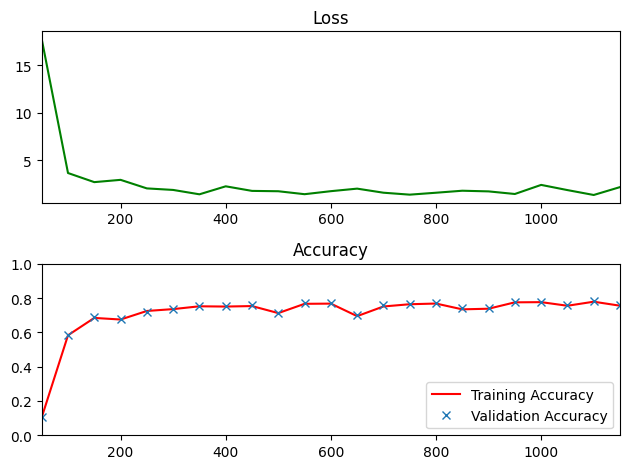

Validation accuracy at 0.7501333355903625


In [39]:
# Change if you have memory restrictions
batch_size = 128

# TODO: Find the best parameters for each configuration
epochs = 1
learning_rate = 0.5

### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.compat.v1.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):

        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')

        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

## Test
You're going to test your model against your hold out dataset/testing data.  This will give you a good indicator of how well the model will do in the real world.  You should have a test accuracy of at least 80%.

> **Eksplorasi**: Setelah model di training, selanjutnya dilakukan test kepada model tersebut menggunakan kumpulan data hold out/data pengujian anda. Ini akan memberikan anda indikator yang baik tentang seberapa baik kinerja model bekerja di dunia nyata. Anda harus memiliki akurai pengujian minimal 80%.

In [41]:
### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.compat.v1.Session() as session:

    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):

        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')

        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch  1/1: 100%|██████████| 1114/1114 [00:01<00:00, 823.32batches/s]


Nice Job! Test Accuracy is 0.8264999985694885


# Multiple layers
Good job!  You built a one layer TensorFlow network!  However, you might want to build more than one layer.  This is deep learning after all!  In the next section, you will start to satisfy your need for more layers.